In [2]:
# If you need some dependencies
!pip install dash reservoirpy stream_benchmark matplotlib seaborn

In [3]:
import reservoirpy as rpy

rpy.verbosity(0)
rpy.set_seed(42)

## Optimize hyperparameters

## Step 1: define the objective

In [4]:
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.observables import nrmse, rsquare
import numpy as np


# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset

    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]

    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed

    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N,
            sr=sr,
            lr=lr,
            input_scaling=input_scaling,
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)

        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

## Step 2: define the research space

In [10]:
import json

hyperopt_config = {
    "exp": "hyperopt-doublescroll",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 1,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 100],             # the number of neurons is fixed to 100
        "sr": ["loguniform", 1e-5, 1e2],   # the spectral radius is log-uniformly distributed from 1e-5 and 100
        "lr": ["loguniform", 1e-5, 1.0],    # idem with the leaking rate, from 1e-5 to 1
        "input_scaling": ["choice", 1.0],   # the input scaling is fixed
        "ridge": ["loguniform", 1e-6, 1e6],        # regularization parameter is explored widely
        "seed": ["randint", 0, 2**32]          # seeds used for random initialisation of weights matrices
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

## Step 3: prepare the data

In [11]:
from reservoirpy.datasets import doublescroll, to_forecasting

timesteps = 2000
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")

train_len = 100
forecast = 2

dataset = to_forecasting(X, forecast=forecast, test_size=train_len-forecast)



## Step 4: launch *hyperopt*

In [12]:
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|████████████████████████████████████| 200/200 [00:25<00:00,  7.98trial/s, best loss: 0.0022520865129672628]


## Step 5 : plot report

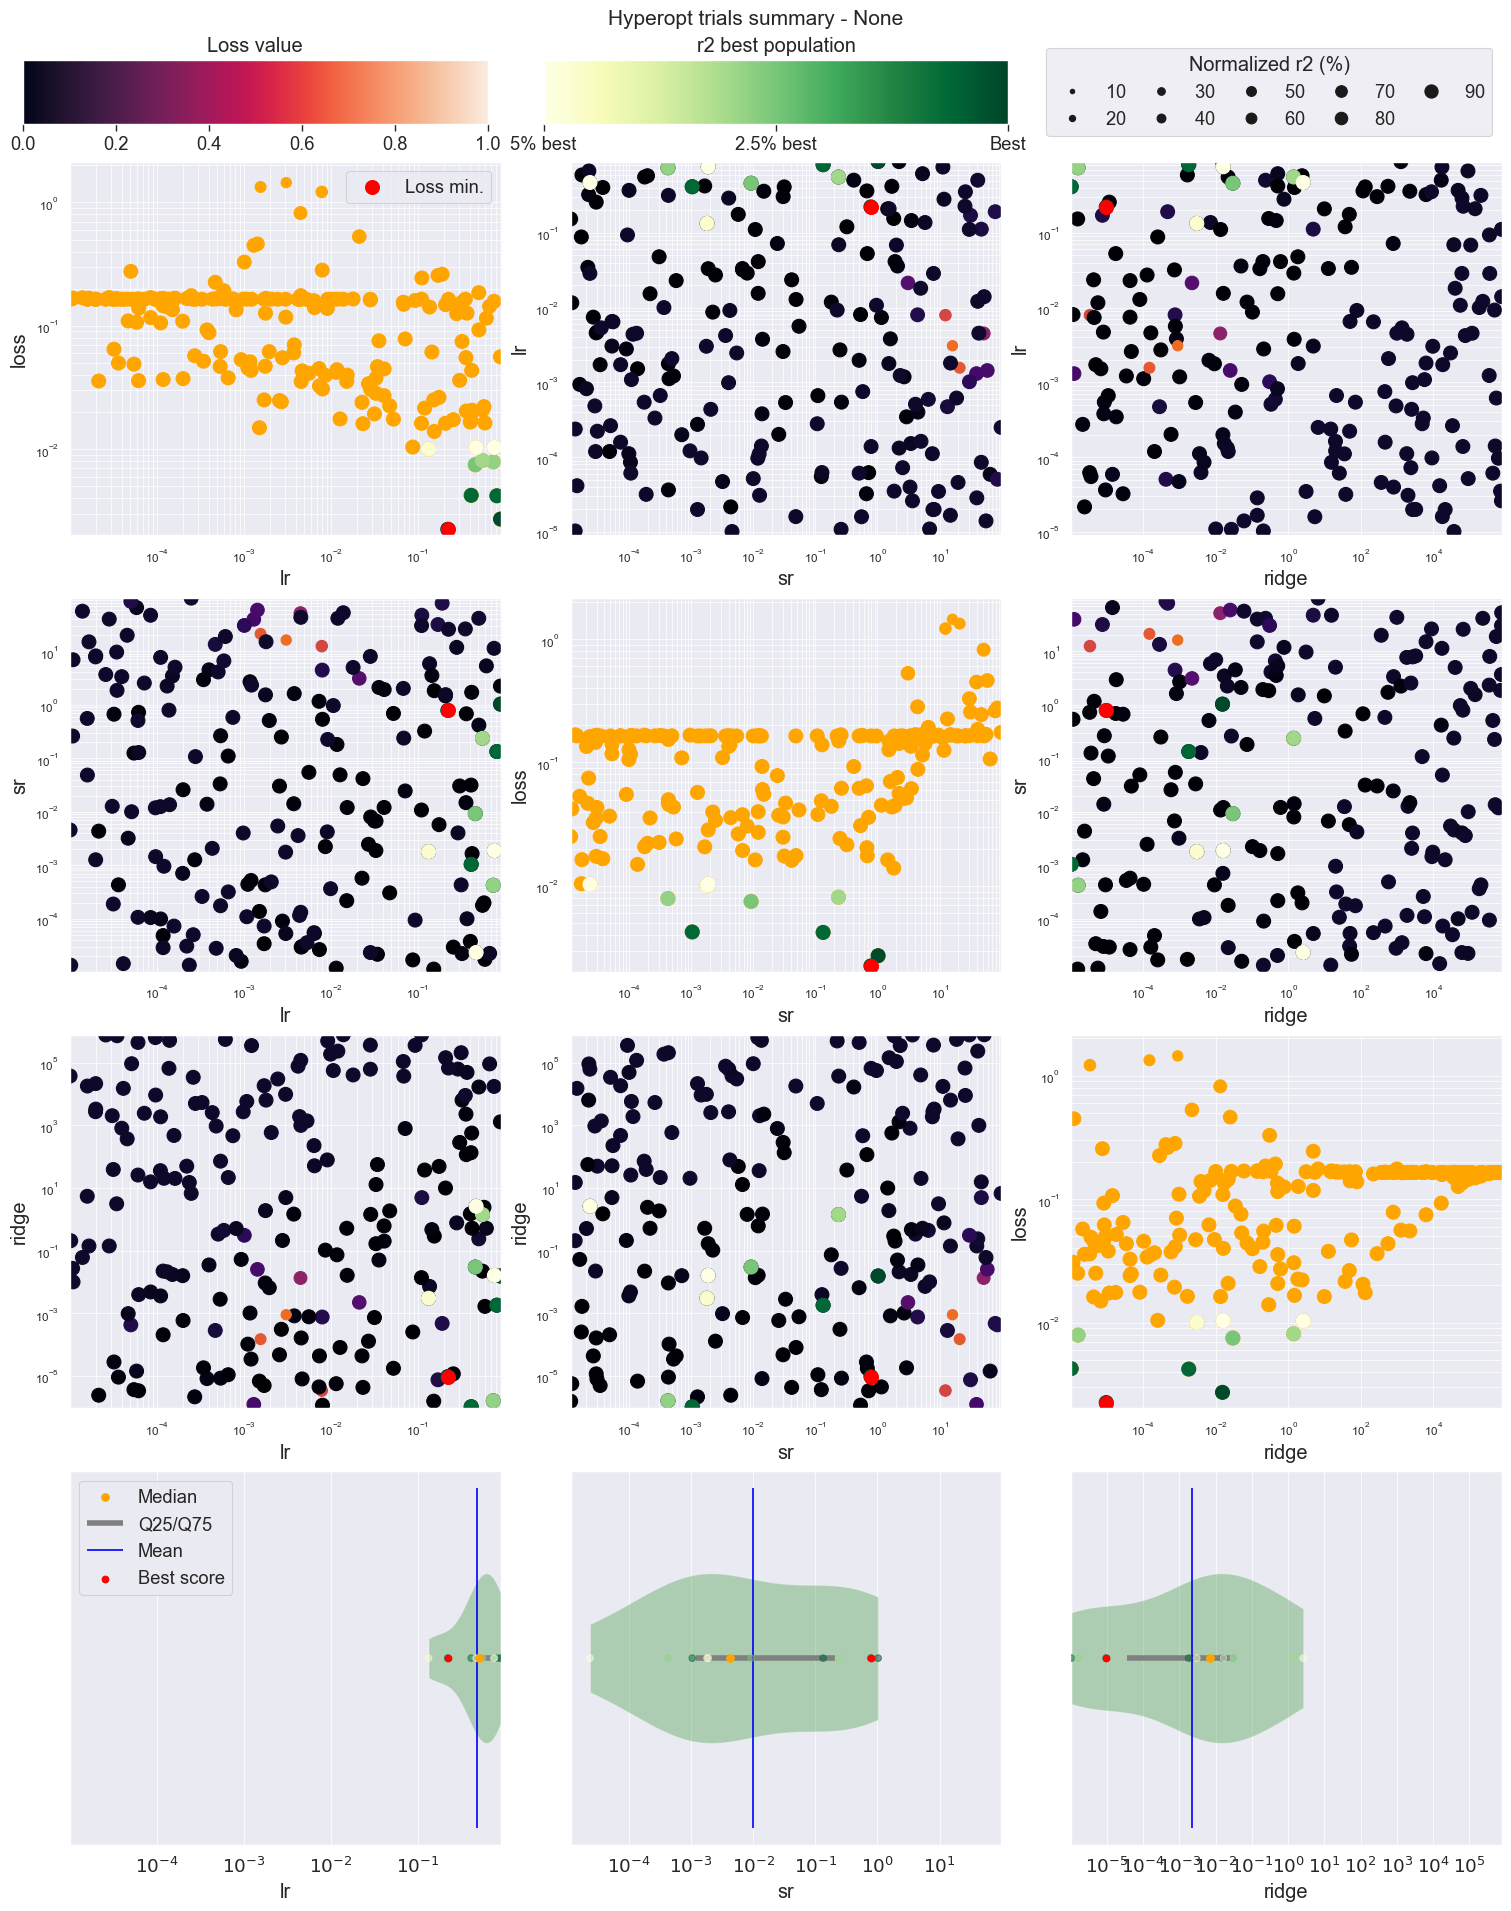

In [13]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

## Step 6 : interactive report

In [14]:
import dash
from dash import dcc, html, Input, Output
import json
import os
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from itertools import combinations


def _get_results(exp):
    report_path = os.path.join(exp, "results")
    results = []
    for file in os.listdir(report_path):
        if os.path.isfile(os.path.join(report_path, file)):
            with open(os.path.join(report_path, file), "r") as f:
                results.append(json.load(f))
    return results


def interactive_report(exp, params, metric='loss', log_loss=False, out_path=None):
    results = _get_results(exp)

    data = {param: np.zeros(len(results)) for param in params}
    data[metric] = np.zeros(len(results))

    for i in range(len(results)):
        for param in params:
            data[param][i] = results[i]['current_params'][param]
        data[metric][i] = results[i]['returned_dict'][metric]

    df = pd.DataFrame(data)

    param_pairs = list(combinations(params, 2))

    app = dash.Dash(__name__)

    app.layout = html.Div([
        html.Div([
            html.Label(f'Interval for {param} (log scale)'),
            dcc.RangeSlider(
                id=f'slider-{param}',
                min=np.log10(df[param].min())-0.1,
                max=np.log10(df[param].max())+0.1,
                step=0.01,
                value=[np.log10(df[param].min())-0.1, np.log10(df[param].max())+0.1],
                marks=None,
                tooltip={"placement": "bottom", "always_visible": True}
            ),
            dcc.Graph(
                id=f'scatter-{param}',
                style={
                    'height': '95%',
                    'width': '100%',
                    'margin': '0'
                }
            )
        ], style={
            'flex': '1',
            'height': '95vh',
            'padding': '0',
            'margin': '0',
            'boxSizing': 'border-box',
            'overflow': 'hidden'
        })

        for param in params
    ], style={
        'display': 'flex',
        'flexDirection': 'row',
        'width': '100vw',
        'height': '100vh',
        'margin': '0',
        'padding': '0',
        'overflow': 'hidden'
    })

    @app.callback(
        [Output(f'scatter-{param}', 'figure') for param in params],
        [Input(f'slider-{param}', 'value') for param in params]
    )
    def update_graphs(*intervals):
        limits = [(10 ** interval[0], 10 ** interval[1]) for interval in intervals]

        if out_path is not None:
            with open(os.path.join(out_path), 'w') as f:
                json.dump({param: [10 ** interval[0], 10 ** interval[1]] for param, interval in zip(params, intervals)}, f)

        insides = [
            (df[param] >= low) & (df[param] <= high)
            for param, (low, high) in zip(params, limits)
        ]

        inside_all = np.logical_and.reduce(insides)

        figs = []

        for param, (low, high) in zip(params, limits):
            fig = go.Figure()
            fig.add_trace(go.Scatter(
                x=df[param],
                y=df[metric],
                mode='markers',
                marker=dict(
                    color=df['loss'],  # Color mapped by rank
                    colorscale='Viridis',  # Color scale
                    size=[10 if inside_all[i] else 5 for i in range(len(df))],
                    opacity=[0.7 if inside_all[i] else 0.3 for i in range(len(df))]
                )
            ))
            fig.update_layout(
                #title=f'{metric} vs {param}',
                xaxis=dict(
                    title=param,
                    type='log',
                    tickformat=".0e",
                ),
                yaxis=dict(
                    title=metric,
                    type='log' if log_loss else 'linear',
                    tickformat=".0e" if log_loss else ".2f"
                ),
                shapes=[
                    dict(
                        type='rect',
                        x0=low,
                        x1=high,
                        y0=0,
                        y1=1,
                        yref='paper',
                        fillcolor='LightGray',
                        opacity=0.3,
                        layer='below',
                        line_width=0,
                    )
                ],
                margin=dict(l=0, r=0, t=0, b=100),
            )

            figs.append(fig)

        return figs

    app.run(debug=True)


### Start interactive report

Start interactive report, it write the selected intervals in `out_path='limits.json'`

In [15]:
interactive_report(hyperopt_config['exp'], ['lr', 'sr', 'ridge'], log_loss=True, out_path='limit.json')

## Refine the search space

Let's refine the search space based on the new ranges we have found for the hyperparameters.
And let's now allow the input scaling to vary to potentially find better optimum.

In [17]:
import json

hyperopt_config = {
    "exp": "hyperopt-doublescroll-refined-01",    # the experimentation name changed (so we can save the results in another folder)
    "hp_max_evals": 200,              
    "hp_method": "random",           
    "seed": 42,                    
    "instances_per_trial": 1,       
    "hp_space": {                   
        "N": ["choice", 100],            
        "sr": ["loguniform", 1e-5, 1e2],    # we keep the SR ranges unchanged because the ranges seem already good and don't change much the loss
        "lr": ["loguniform", 10**(-2.34), 1.0],    # change to new find range values 
        "input_scaling": ["loguniform", 1e-5, 1e2],    # making the input scaling variable: we take the same values as SR
        "ridge": ["loguniform", 1e-10, 10**(-0.32)],       # we reduced the range on the right-hand part and augment it on the left-hand part
        "seed": ["randint", 0, 2**32]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [18]:
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|████████████████████████████████████| 200/200 [00:27<00:00,  7.15trial/s, best loss: 0.0022299035938198155]


Most of the time we see that the best loss found is lower. Let's look at the plots, adding the newly varying parameter: input scaling.

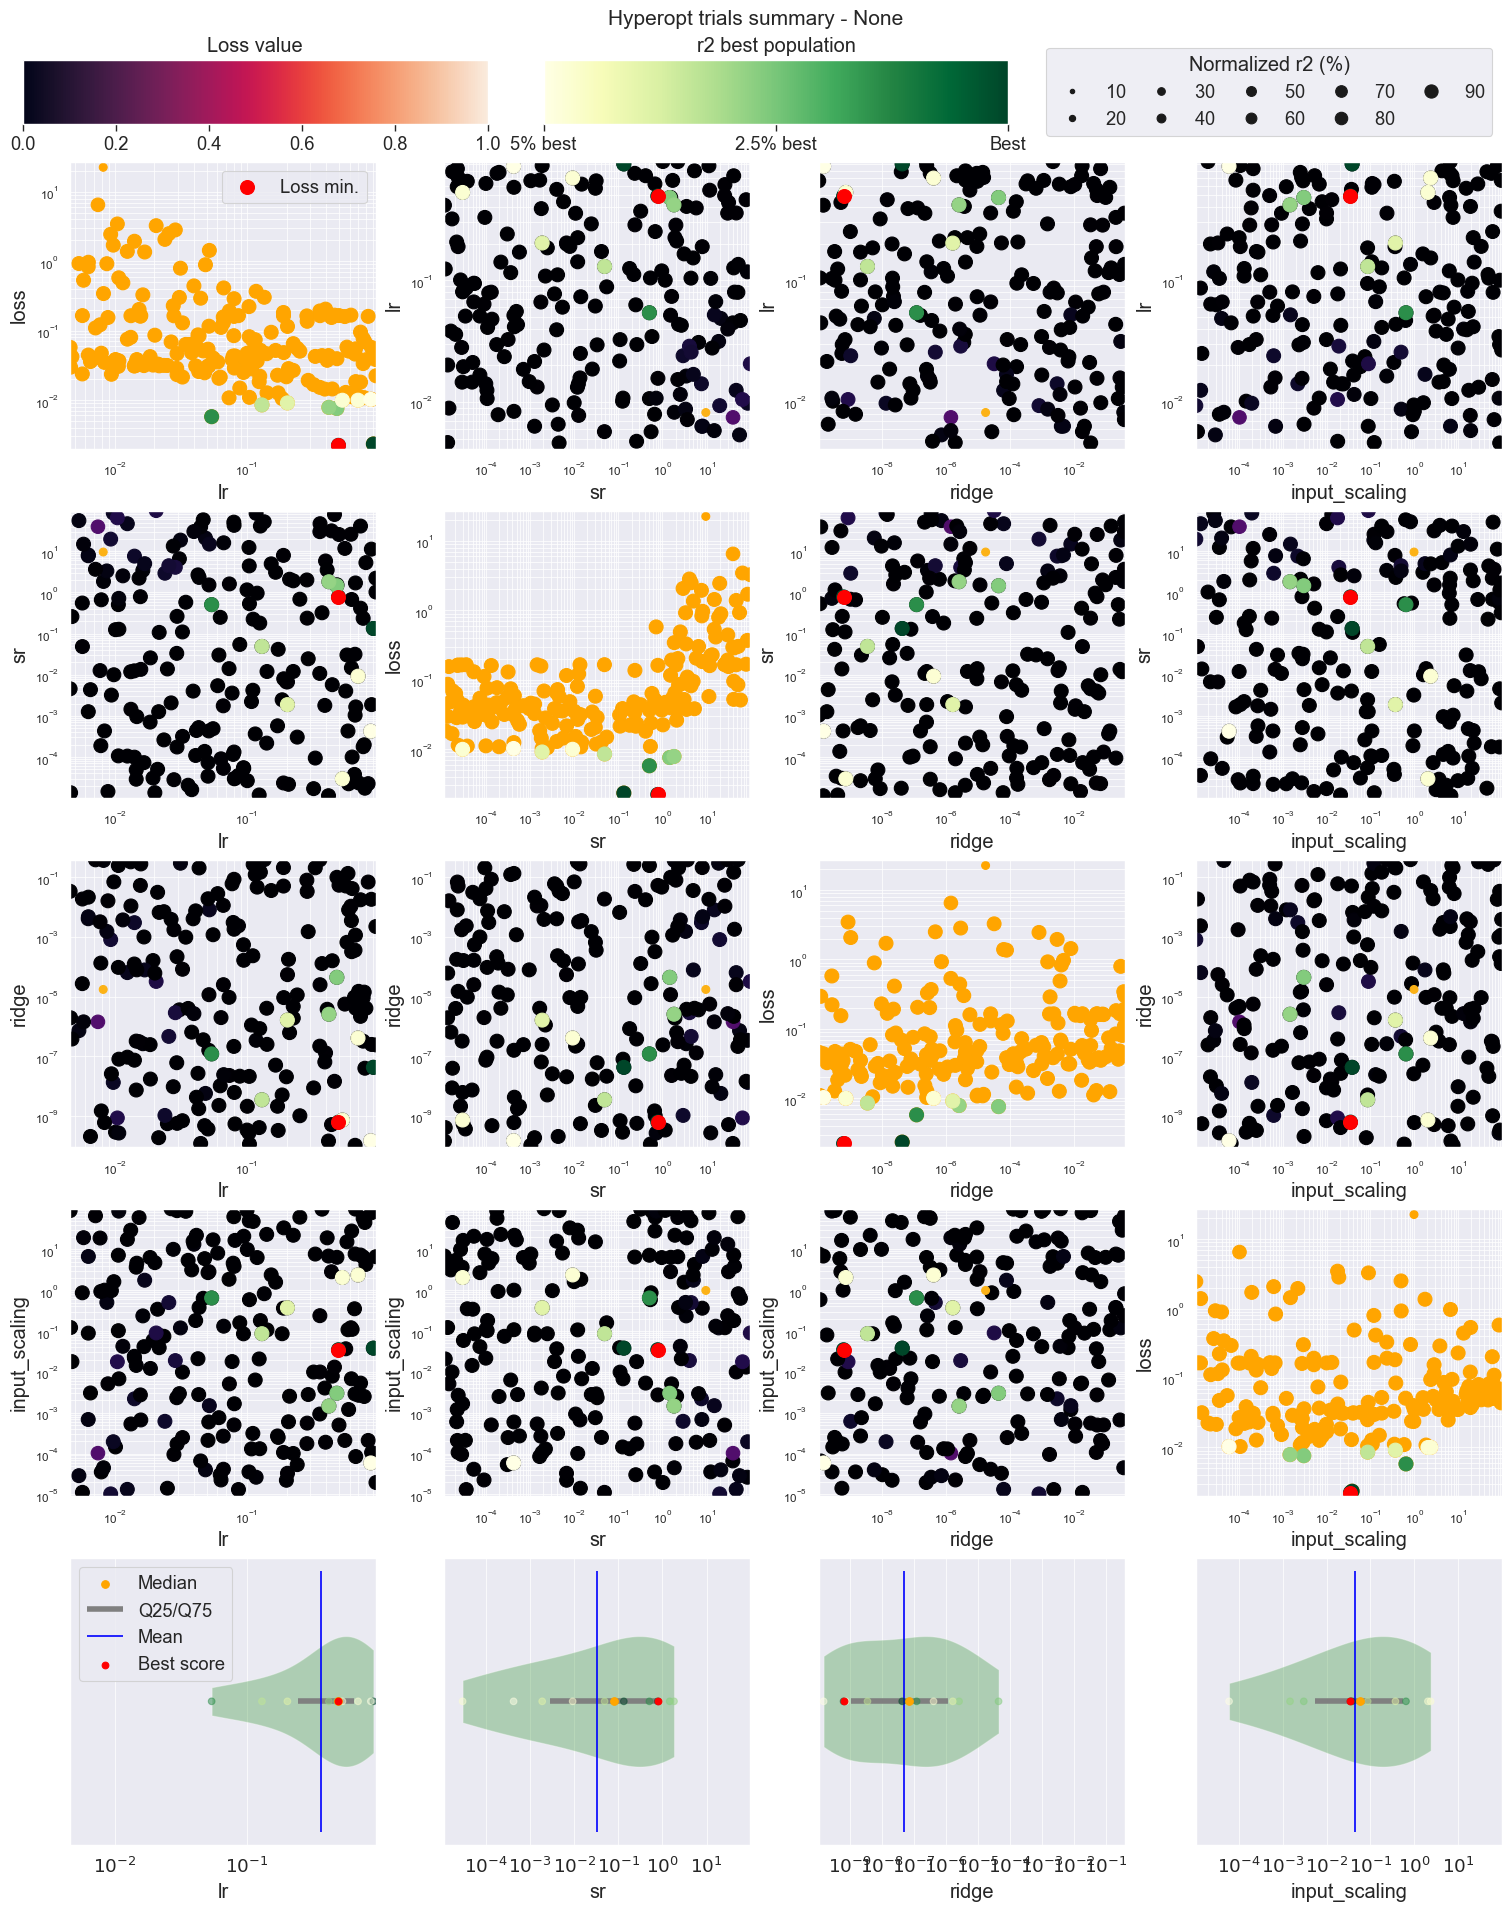

In [19]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge", "input_scaling"), metric="r2")

In [20]:
interactive_report(hyperopt_config['exp'], ['lr', 'sr', 'ridge', 'input_scaling'], log_loss=True, out_path='limit.json')

We quickly found good ranges for reservoir instances to have **good and robust** results. We could now launch an optimiser like TPE (also in hyperopt).